In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import SALS as LS

# Small Angle Light Scattering (SALS)

```SALS``` class is designed to analyze far-field light scattering experiments in the small-angle configuration, where image pixels map not in different locations of the sample (as in DSH) but in differetn scattering vectors. A typical speckle field in SALS experiment looks like this:

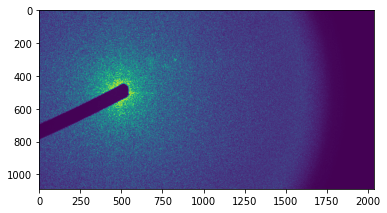

In [7]:
im_shape = (1088, 2040)
plt.imshow(MI.ReadBinary('..\\SALS_test\\sample_image.raw', im_shape, 'B'))

The speckle intensity here is not homogeneous as in DSH, but increases moving towards a point, which is the location where the transmitted beam would hit the detector, if there wasn't the black shadow of the beam stop blocking it. The fist step of a SALS analysis, essential to map pixel location in scattering vector (```centerPos```), is to identify the transmitted beam location, and to create a binary mask (```maskRaw```) to exclude from the analysis the pixels shadowed by the beam stop.
By design, ```SALS``` expects that ```centerPos``` is a couple of floats ```(posX, posY)``` specifying the location of the center in pixels, relative to the upper left corner of the image. The upper left corner location is ```(0, 0)```.

Once ```centerPos``` is specified, the analysis can be specialized on annular regions around the center, thereby averaging on scattering vectors of equal magnitude and different azimuthal orientation. 

Azimuthal annuli can be generated using ```GenerateROIs(ROI_specs, imgShape, centerPos, maskRaw)```, where ```ROI_specs=[rSlices, aSlices]```:

In [ ]:
ROI_specs = [np.geomspace(50, 1000, 10), (-np.pi, np.pi)]
px_mask = plt.imshow(MI.ReadBinary('..\\SALS_test\\px_.raw', im_shape, 'B'))
LS.GenerateROIs(ROI_specs, im_shape, [500, 500], )

In [2]:
test_SALS = LS.LoadFromConfig('DSH\\serial_SALS_config.ini')

In [3]:
test_SALS.Run(doDLS=True)

ValueError: operands could not be broadcast together with shapes (20,) (0,) 

In [3]:
test_SALS.AverageG2M1()

In [7]:
test_shape = (1088, 2040)
test_img = np.arange(np.prod(test_shape)).reshape(test_shape)
test_weight = np.ones_like(test_img)
test_mask = (test_img % 2 == 0)
%timeit res1 = np.sum(test_img[test_mask]) / np.sum(test_weight[test_mask])
%timeit res2 = np.sum(np.multiply(test_img, test_mask)) / np.sum(np.multiply(test_weight, test_mask))

16.6 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.45 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
